In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Embedding, Dense, LSTM, Dropout, TimeDistributed, RepeatVector
from collections import Counter
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.losses import SparseCategoricalCrossentropy

In [2]:
df = pd.read_csv("./data/eng-french.csv")
df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [3]:
df.shape

(175621, 2)

In [4]:
eng = df["English words/sentences"]
fre = df["French words/sentences"]

In [5]:
eng_word_counter = Counter([word for sentence in eng for word in sentence.split()])
print("total count of English words",len([word for sentence in eng for word in sentence.split()

]))
print("count of distinct English words",len(eng_word_counter))
print("10 most common english words",list(zip(*eng_word_counter.most_common(10)))[0])

total count of English words 1082098
count of distinct English words 27393
10 most common english words ('I', 'to', 'you', 'the', 'a', 'is', 'Tom', 'of', 'in', 'have')


In [6]:
fre_word_counter = Counter([word for sentence in fre for word in sentence.split()])
print("total count of french words", len([word for sentence in fre for word in sentence.split()]))
print("total count of  distict english words", len(fre_word_counter))
print("10 most common french words",list(zip(*fre_word_counter.most_common(10)))[0])

total count of french words 1177832
total count of  distict english words 44918
10 most common french words ('de', 'Je', '?', 'pas', 'que', 'à', 'ne', 'la', 'le', 'Il')


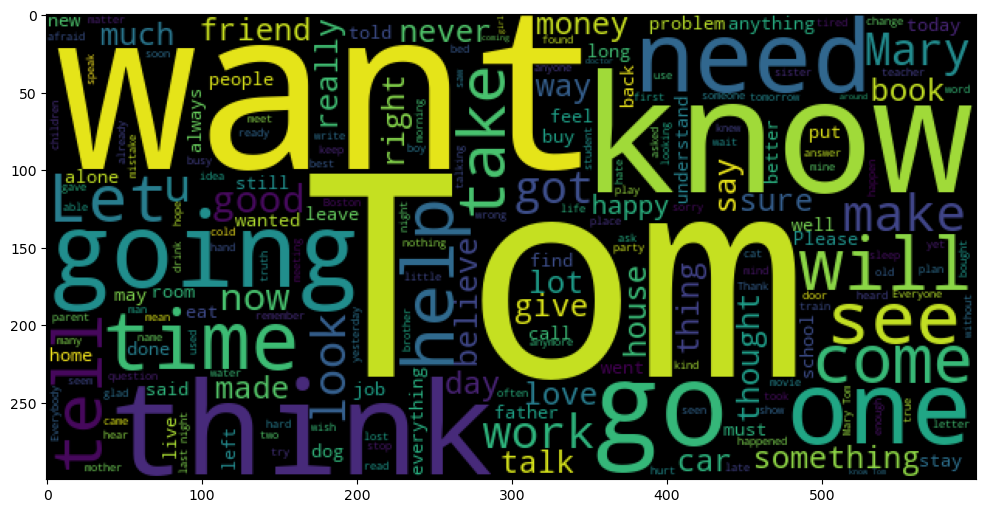

In [7]:
plt.figure(figsize=(12,12))
wc = WordCloud(width=600,height=300).generate(" ".join(eng))
plt.imshow(wc)
plt.show()

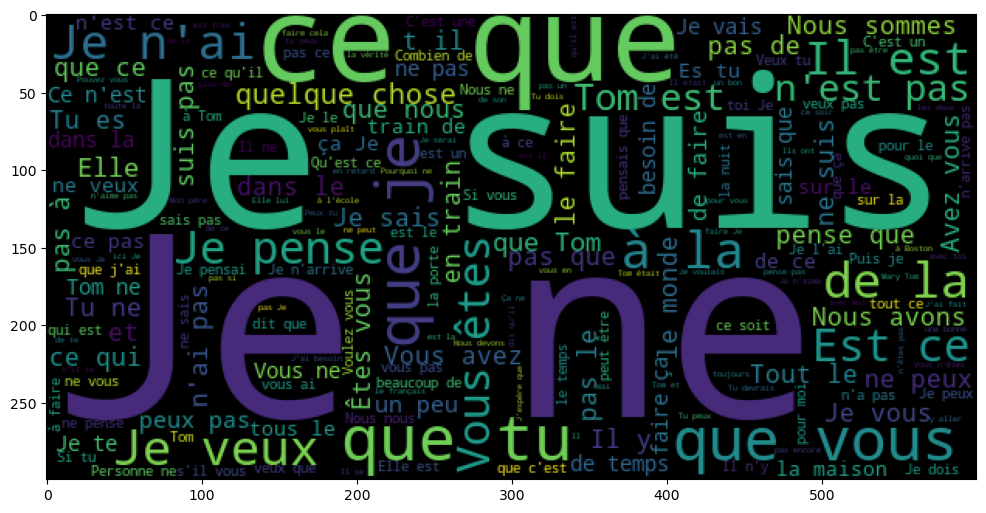

In [8]:
plt.figure(figsize=(12,12))
wc = WordCloud(width=600,height=300).generate(" ".join(fre))
plt.imshow(wc)
plt.show()

In [9]:
def create_tokenizer(sentences,num_words = None,oov_token = "<OOV>"):
    tokenizer = Tokenizer(num_words=num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
                         lower=True, 
                         split=' ',
                         oov_token=oov_token)
    tokenizer.fit_on_texts(sentences)
    return tokenizer

In [10]:

def max_sentence_length(lines):
  return max(len(sentence.split()) for sentence in lines)

In [11]:
def encode_sequences(tokenizer,sentences,max_setence_length):
    text_to_seq = tokenizer.texts_to_sequences(sentences) # encode sequences with integers
    text_pad_seq = pad_sequences(text_to_seq,maxlen=max_setence_length,padding="post")
    return text_pad_seq

In [12]:
from gensim.models import KeyedVectors

en_vectors = KeyedVectors.load_word2vec_format("wiki.en.align.vec",encoding="utf-8")
fr_vectors = KeyedVectors.load_word2vec_format("wiki.fr.align.vec",encoding="utf-8")

In [13]:
def create_embedding_matrix(word_index,vector_model,embedding_dim=300):
    matrix = np.zeros((len(word_index)+1,embedding_dim))
    for word, i in word_index.items():
        if word in vector_model:
            matrix[i] = vector_model[word]
        else:
            matrix[i] = np.random.normal(size=embedding_dim)
    return matrix


In [14]:
eng_tokenizer = create_tokenizer(eng)
eng_vocab_size = len(eng_tokenizer.word_index) + 1
max_english_sent_len = max_sentence_length(eng)  # Corrected function name
print("English vocabulary size:", eng_vocab_size)
print("Maximum length of English sentences:", max_english_sent_len)

English vocabulary size: 14533
Maximum length of English sentences: 44


In [15]:
fre_tokenizer = create_tokenizer(fre)
fre_vocab_size = len(fre_tokenizer.word_index) +1
max_fre_sent_len = max_sentence_length(fre)
print("French vocabulary size:", fre_vocab_size)
print("Maximum length of French sentences:", max_fre_sent_len)

French vocabulary size: 30662
Maximum length of French sentences: 55


In [16]:

max_eng_sent_len = 22
max_fre_sent_len = 22

In [17]:
encoder_embedding_matrix = create_embedding_matrix(eng_tokenizer.word_index, en_vectors)
decoder_embedding_matrix = create_embedding_matrix(fre_tokenizer.word_index, fr_vectors)


In [18]:
X  = encode_sequences(eng_tokenizer,eng,max_eng_sent_len)
y = encode_sequences(fre_tokenizer,fre,max_fre_sent_len)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15,shuffle=True,random_state=101)


In [20]:
encoder_embedding_matrix = create_embedding_matrix(eng_tokenizer.word_index,en_vectors)
decoder_embedding_matrix = create_embedding_matrix(fre_tokenizer.word_index,fr_vectors) 

In [21]:
def create_model(src_vocab_size,dest_vocab_size,src_timesteps,dest_timesteps,n_units,embedding_matrix):
    model = Sequential()
    model.add(Embedding(src_vocab_size,300, weights=[embedding_matrix], input_length = src_timesteps, mask_zero = True))
    model.add(LSTM(n_units))
    model.add(RepeatVector(dest_timesteps))

    #decoder
    model.add(LSTM(n_units, return_sequences= True))
    model.add(TimeDistributed(Dense(dest_vocab_size,activation="softmax")))
  # Compile model
    model.compile(optimizer='adam', 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])   
    return model


In [22]:
n_units = 512
model = create_model(src_vocab_size=eng_vocab_size,dest_vocab_size=fre_vocab_size, src_timesteps=max_english_sent_len,dest_timesteps=max_fre_sent_len,n_units=n_units, embedding_matrix=encoder_embedding_matrix)

model.summary()

c:\Users\Hp\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     4,359,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ ?                      │   0 (unbuilt) │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,359,900 (16.63 MB)

 Trainable params: 4,359,900 (16.63 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
early_stopping = EarlyStopping(monitor="val_loss",patience=3,restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


In [24]:
y_train_reshaped = y_train.reshape(y_train.shape[0],y_train.shape[1],1)
y_test_reshaped = y_test.reshape(y_test.shape[0], y_test.shape[1], 1)


In [25]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available: 0


In [ ]:
#train model
history = model.fit(X_train,y_train_reshaped,epochs=20,batch_size=32,validation_data=(X_test,y_test_reshaped),callbacks=[early_stopping,reduce_lr])

Epoch 1/20
4665/4665 ━━━━━━━━━━━━━━━━━━━━ 3080s 659ms/step - accuracy: 0.7115 - loss: 2.3243 - val_accuracy: 0.7491 - val_loss: 1.7245 - learning_rate: 0.0010
Epoch 2/20
4665/4665 ━━━━━━━━━━━━━━━━━━━━ 3127s 670ms/step - accuracy: 0.7592 - loss: 1.5943 - val_accuracy: 0.7794 - val_loss: 1.3412 - learning_rate: 0.0010
Epoch 3/20
4665/4665 ━━━━━━━━━━━━━━━━━━━━ 6585s 1s/step - accuracy: 0.7881 - loss: 1.1930 - val_accuracy: 0.7972 - val_loss: 1.1175 - learning_rate: 0.0010
Epoch 4/20
4665/4665 ━━━━━━━━━━━━━━━━━━━━ 2832s 607ms/step - accuracy: 0.8095 - loss: 0.9228 - val_accuracy: 0.8076 - val_loss: 1.0152 - learning_rate: 0.0010
Epoch 5/20
4665/4665 ━━━━━━━━━━━━━━━━━━━━ 2990s 641ms/step - accuracy: 0.8269 - loss: 0.7565 - val_accuracy: 0.8127 - val_loss: 0.9728 - learning_rate: 0.0010
Epoch 6/20
4665/4665 ━━━━━━━━━━━━━━━━━━━━ 2911s 624ms/step - accuracy: 0.8418 - loss: 0.6493 - val_accuracy: 0.8163 - val_loss: 0.9519 - learning_rate: 0.0010
Epoch 7/20
4665/4665 ━━━━━━━━━━━━━━━━━━━━ 2853s 6

In [ ]:
model.save('english_to_french_translator.h5')


In [ ]:
def translate_english_to_french(sentence, model, eng_tokenizer, fre_tokenizer, max_length=22):
    """
    Translate an English sentence to French
    
    Args:
        sentence: Input English sentence as string
        model: Trained translation model
        eng_tokenizer: English tokenizer
        fre_tokenizer: French tokenizer
        max_length: Maximum sentence length (default: 22)
        
    Returns:
        French translation as string
    """
    # Preprocess the input sentence
    sequence = eng_tokenizer.texts_to_sequences([sentence])
    padded_sequence = pad_sequences(sequence, maxlen=max_length, padding='post')
    
    # Make prediction
    prediction = model.predict(padded_sequence, verbose=0)
    
    # Get the predicted word indices
    predicted_indices = np.argmax(prediction, axis=-1)[0]
    
    # Convert prediction to French sentence
    french_sentence = ''
    for idx in predicted_indices:
        if idx > 0:  # Skip padding (0)
            word = fre_tokenizer.index_word.get(idx, '')
            if word:
                french_sentence += word + ' '
    
    return french_sentence.strip()

# Example usage:
test_sentences = [
    "hello",
    "how are you",
    "thank you very much",
    "where is the bathroom"
]

for sentence in test_sentences:
    translation = translate_english_to_french(sentence, model, eng_tokenizer, fre_tokenizer)
    print(f"English: {sentence}")
    print(f"French: {translation}")
    print("-" * 40)